## Variance component selection for a univariate response model
### : simulation using R `SKAT.haplotypes` data

The package `VarianceComponentSelect` has not yet been registered and must be installed using the repository location. Start julia and use the `]` key to switch to the package manager REPL:
```julia
(v0.7) pkg> add https://github.com/juhkim111/VarianceComponentSelect.jl.git
```
Use the backspace key to return to the Julia REPL.

In [4]:
using VarianceComponentSelect

We use haplotype data ([`SKAT.haplotypes`](https://cran.r-project.org/web/packages/SKAT/SKAT.pdf#page=23)) in R [`SKAT`](https://cran.r-project.org/web/packages/SKAT/SKAT.pdf) package to generate genotype matrix. This dataset is generated by calibration coalescent model (COSI) with mimicking LD structure of European ancestry.
Load `RCall` package, which allows us to call R packages from within Julia.

In [5]:
using RCall

In [6]:
R"""
    packages <- c("SKAT", "gglasso")
    if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
    install.packages(setdiff(packages, rownames(installed.packages())))
    }
    library(SKAT)
    data("SKAT.haplotypes")
    Haplotype <- SKAT.haplotypes$Haplotype
    SNPInfo <- SKAT.haplotypes$SNPInfo
""";

`SKAT.haplotypes` consists of two objects: `Haplotype` matrix and `SNPInfo` dataframe.
`Haplotype` is a matrix of size $10,000\times 3845$ where each row represents a different haplotype and each column represents a different SNP marker. 

In [7]:
@rget Haplotype

10000×3845 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  

`SNPInfo` contains information about 3845 SNPs in `Haplotype` matrix. All SNPs come from chromosome 1, and chromosome position ranges from 79 to 199956, or over 200k base pair region. 

In [8]:
@rget SNPInfo

,SNP,CHROM,CHROM_POS,ALLELE1,FREQ1,ALLELE2,FREQ2
,Int64,Int64,Int64,Int64,Float64,Int64,Float64
1,1,1,79,1,0.0008,2,0.9992
2,2,1,281,1,0.0001,2,0.9999
3,3,1,344,1,0.0001,2,0.9999
4,4,1,385,1,0.001,2,0.999
5,5,1,403,1,0.0011,2,0.9989
6,6,1,428,1,0.1387,2,0.8613
7,7,1,501,1,0.1051,2,0.8949
8,8,1,536,1,0.0011,2,0.9989
9,9,1,607,1,0.0015,2,0.9985


Assume one gene to be 5kb long, which translates to having 40 genes. We also assume sample size to be 500.

In [9]:
m = 40 # no. of genes
pj = 5000 # gene size 
n = 500 # sample size

500

Suppose that there are 5 causal genes, and that they are evenly spread across all 40 genes/groups. 

In [10]:
σ2 = zeros(m + 1)
σ2[end] = 1.0
for iter in Int.(round.(range(1, stop=m, length=5)))
     σ2[iter] = 5.0
end

These genes have positive variance components:

In [11]:
Int.(round.(range(1, stop=m, length=5)))

5-element Array{Int64,1}:
  1
 11
 20
 30
 40

Set seed first. 

In [12]:
using Random
Random.seed!(123);

To create a genotype matrix whose entries consist of {0,1,2}, we select `2n` rows from `Haplotype` without replacement and add the first `n` rows to the last `n` rows.

In [13]:
using StatsBase, LinearAlgebra
n = 500 # sample sizE 
idx = zeros(Int64, 2n)
sample!(1:size(Haplotype, 1), idx; replace=false)

# add two haplotype matrices to create a big block of genotype matrix
G = Haplotype[idx[1:n], :] + Haplotype[idx[n + 1:end], :]

500×3845 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  2  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  2  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  0  0  0  0  0  0  2  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0 

Now we construct covariance matrices `V[i]` for each `i`-th gene by dividing up `G` matrix by chromosome position (5000kb), multiplying by its transpose, and dividing by its Frobenius norm. 
Ultimately, we add these covariance matrices multiplied by variance component to create the overall covariance matrix `Ω`.

In [14]:
## construct covariance matrix Ω
Ω  = zeros(n, n)
grp_id = zeros(Int64, size(Haplotype, 2))
V  = Array{Matrix{Float64}}(undef, m + 1)
for k in 1:m
    local k
    i = k
    grp_id[(SNPInfo.CHROM_POS .> pj * (i-1)) .& (SNPInfo.CHROM_POS .<= pj * i)] .= i
    Vi = view(G, :, grp_id .== i)
    V[i] = Vi * Vi'
    V[i] ./= norm(V[i])
    Ω .+= σ2[i] .* V[i]
end
V[m + 1] = Matrix{Float64}(I, n, n) / √n
Ω .+= σ2[m + 1] .* V[m + 1]
Ωchol = cholesky(Hermitian(Ω)) # cholesky factorization after making it symmetric 

Cholesky{Float64,Array{Float64,2}}
U factor:
500×500 UpperTriangular{Float64,Array{Float64,2}}:
 0.286665  0.0308989  0.0         0.0929487   …   0.0           0.0189187  
  ⋅        0.314658   0.0736505   0.0190226       0.101801      0.0264071  
  ⋅         ⋅         0.31854    -0.00439827      0.104943      0.0218148  
  ⋅         ⋅          ⋅          0.351454        0.0575279     0.0555649  
  ⋅         ⋅          ⋅           ⋅              0.0366417     0.0350243  
  ⋅         ⋅          ⋅           ⋅          …   0.0636818     0.0445843  
  ⋅         ⋅          ⋅           ⋅              0.0735116     0.0241263  
  ⋅         ⋅          ⋅           ⋅              0.0334636    -0.0561523  
  ⋅         ⋅          ⋅           ⋅             -0.0718995     0.118174   
  ⋅         ⋅          ⋅           ⋅              0.0737071    -0.00769136 
  ⋅         ⋅          ⋅           ⋅          …   0.00933045    0.00570924 
  ⋅         ⋅          ⋅           ⋅             -0.014867      0.01

Finally, we create a response vector using the Cholesky factorization.

In [15]:
y = Ωchol.L * randn(n)

500-element Array{Float64,1}:
  0.059889941943584386
  0.06824553481637262 
 -0.29290706471620015 
  0.08978502507920363 
  0.6397891195270545  
 -0.014517537765035669
 -1.6023858737232344  
 -0.7841014472220409  
 -1.1041977245535062  
 -0.20279368671486095 
  0.8365223133572526  
  0.37968925223209127 
 -0.20229457721826052 
  ⋮                   
  0.21925045485687303 
  0.08737564271358689 
 -0.18967924309033846 
 -0.43192159964878957 
  0.30631547857769326 
 -0.8258313372086057  
 -0.11582926210791059 
  0.2672375561735326  
  0.2615727818393714  
  0.1694015518084827  
 -0.4081986034117404  
 -0.680984950494975   

We also generate a covariate matrix with 3 covariates. 

In [16]:
p = 10
X = randn(n, p)

500×10 Array{Float64,2}:
 -0.357512  -1.20512    0.456071   …   0.469279   -0.4246      -0.180256 
  1.10493    0.510995   1.78939        1.05211     0.190831    -1.54762  
  0.360943  -0.797932   2.36725       -0.607956    0.0199318   -0.327498 
  1.07779    1.01809   -1.301          0.775929   -0.412176     1.16717  
  0.211548   0.887211   2.27531       -2.34106     0.0259707   -2.4649   
 -2.1254    -1.2528    -2.61588    …   0.47917     0.170861    -0.90011  
  1.04942    1.20896    0.0358361     -0.458283   -0.667652     2.04367  
 -0.354441   0.197945  -1.02732        0.313368   -0.358023     1.02745  
 -0.160404  -0.613613  -0.304309       1.7622     -1.33322     -0.571754 
 -0.60608    0.557166   0.0483144     -1.65057     0.969906    -0.123887 
  0.43255    0.968414  -0.755504   …   1.7669      0.172893     1.88857  
 -1.24071   -0.819892   0.665363       1.17051     0.531119    -0.867992 
 -0.528542  -1.16037    1.43009       -0.416337   -0.168258    -0.886616 
  ⋮          

Finally, we are ready to perform variance component selection. 

In [18]:
using PenaltyFunctions

First, let's estimate `σ2` using no penalty.

In [29]:
σ2, obj, = vcselect(y, X, V)

([4.76263, 6.89537e-17, 3.94118e-36, 2.79432e-19, 4.30498e-53, 2.24497e-20, 8.19718e-63, 6.31832e-16, 7.90088e-25, 4.39373e-9  …  1.34213e-53, 0.00622915, 2.3417e-30, 1.80061e-16, 4.93655e-25, 3.85262e-22, 5.24315e-11, 4.07437, 9.637, 0.0391046], -16.24333205061083, 144, [0.165234 0.0544481 … 0.0310792 0.112705; 0.0544481 0.167105 … 0.0153651 0.0151028; … ; 0.0310792 0.0153651 … 0.202942 -0.0132805; 0.112705 0.0151028 … -0.0132805 0.325005], [23.5239 -1.07158 … -0.122228 -0.520898; -1.07158 18.993 … 0.0788421 -0.127254; … ; -0.122228 0.0788421 … 20.9875 -0.197015; -0.520898 -0.127254 … -0.197015 20.2557])

In [47]:
maximum(σ2)

9.637003152115575

We can use the estimates above as a penalty weight for adaptive lasso penalty. 

In [31]:
penwt = zeros(m + 1)
penwt[1:m] = 1 ./ sqrt.(σ2[1:m])

40-element Array{Float64,1}:
      0.4582225003356609   
      1.2042624893842031e8 
      5.037172404194073e17 
      1.89174199222047e9   
      1.524103362627934e26 
      6.674127529742688e9  
      1.104505097094322e31 
      3.978316003854715e7  
      1.1250254032297588e12
  15086.311703429588       
      0.4680106329623046   
      3.5440127538079424e21
      3.502127352276433e9  
      ⋮                    
    122.09181040472501     
      0.34932016248734765  
      8.187365308305049e10 
      2.7296282321200786e26
     12.670258313530718    
      6.534828288331194e14 
      7.452301013392845e7  
      1.4232733370625708e12
      5.094741516953133e10 
 138103.29354726535        
      0.49541565884604527  
      0.3221283881390994   

Here we obtain solution path using three different penalties: lasso (`L1Penalty()`), adaptive lasso, and MCP penalty (`MCPPenalty()`). For MCP penalty, default `γ` value equals to 2.0.

In [40]:
σ2path_lasso, objpath_lasso, λpath_lasso = vcselectPath(y, X, V; penfun=L1Penalty())

([4.76263 4.71122 … 0.0 0.0; 6.89537e-17 0.0 … 0.0 0.0; … ; 9.637 9.77542 … 0.0 0.0; 0.0391046 0.0392404 … 0.0971057 0.0972453], [-16.2433, -10.1653, -4.54223, 1.15906, 6.8603, 8.49131, 13.243, 17.9947, 22.7465, 28.9062  …  286.866, 288.28, 289.691, 291.098, 292.502, 293.903, 295.302, 296.697, 298.089, 299.479], 0.0:0.9503422571628649:94.08388345912363)

In [32]:
σ2path_adlasso, objpath_adlasso, λpath_adlasso = vcselectPath(y, X, V; penfun=L1Penalty(), penwt=penwt)

([4.76263 3.9934 … 0.0 0.0; 6.89537e-17 0.0 … 0.0 0.0; … ; 9.637 7.34859 … 0.224618 0.220574; 0.0391046 0.0405187 … 0.0850204 0.0853353], [-16.2433, -5.61942, 3.2002, 11.3943, 19.0917, 26.3806, 33.3245, 39.9712, 46.3578, 52.5136  …  273.002, 274.349, 275.686, 277.013, 278.33, 279.638, 280.937, 282.225, 283.504, 284.774], 0.0:2.0234638624644923:200.32292238398472)

In [20]:
σ2path_mcp, objpath_mcp, λpath_mcp = vcselectPath(y, X, V; penfun=MCPPenalty())

([4.76263 4.7112 … 0.0 0.0; 6.89537e-17 0.0 … 0.0 0.0; … ; 9.637 9.77551 … 0.0 0.0; 0.0391046 0.0392405 … 0.139217 0.139501], [-16.2433, -10.1653, -5.40545, 0.811947, 7.36727, 13.9743, 20.5094, 26.9356, 33.2243, 39.3753  …  278.916, 280.462, 282.009, 281.601, 272.493, 273.014, 273.532, 274.046, 274.557, 275.065], 0.0:0.9503422571628649:94.08388345912363)

We plot the solution path below.

In [22]:
using Plots; pyplot();

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186
┌ Warning: Module Reexport with build ID 60288655607376 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:941
┌ Info: Precompiling StaticArrays [90137ffa-7385-5640-81b9-e52037218182]
└ @ Base loading.jl:1186
┌ Info: Precompiling PlotUtils [995b91a9-d308-5afd-9ec6-746e21dbc043]
└ @ Base loading.jl:1186
┌ Warning: Module Reexport with build ID 60288655607376 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:941
┌ Info: Precompiling Colors [5ae59095-9a9b-59fe-a467-6f913c188581]
└ @ Base loading.jl:1186
┌ Warning: Module Reexport with build ID 60288655607376 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba9

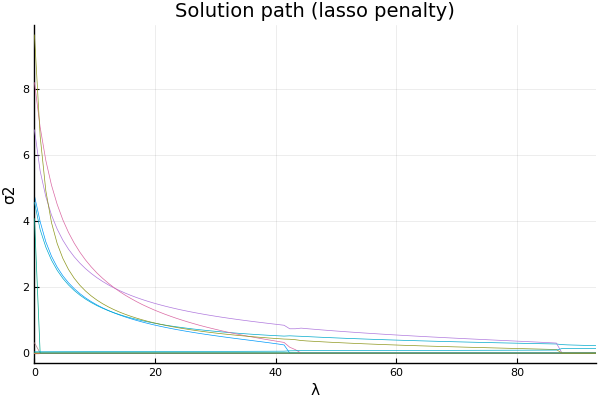

In [41]:
plot(λpath_lasso, σ2path_lasso', label="", xaxis=("λ", (minimum(λpath_lasso), maximum(λpath_lasso))), 
    yaxis=("σ2"), width=0.5)
title!("Solution path (lasso penalty)")

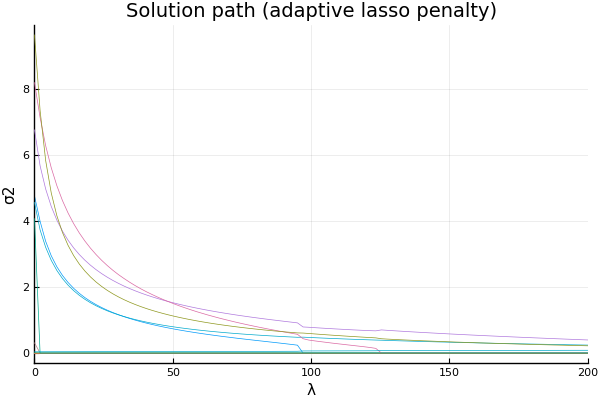

In [42]:
plot(λpath_adlasso, σ2path_adlasso', label="", xaxis=("λ", (minimum(λpath_adlasso), maximum(λpath_adlasso))), 
    yaxis=("σ2"), width=0.5)
title!("Solution path (adaptive lasso penalty)")

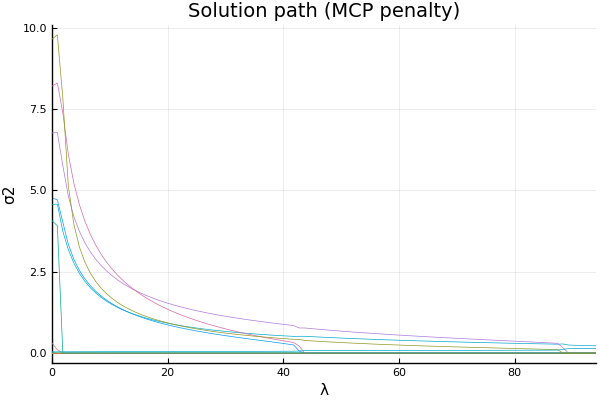

In [25]:
plot(λpath_mcp, σ2path_mcp', label="", xaxis=("λ", (minimum(λpath_mcp), maximum(λpath_mcp))), 
    yaxis=("σ2"), width=0.5)
title!("Solution path (MCP penalty)")

For MCP penalty, we used the default value `γ=2.0`. Instead, let's try `γ=2.67`, and plot the solution path. 

In [26]:
σ2path_mcp, objpath_mcp, λpath_mcp = vcselectPath(y, X, V; penfun=MCPPenalty(2.67))

([4.76263 4.77248 … 0.0 0.0; 6.89537e-17 0.0 … 0.0 0.0; … ; 9.637 9.97102 … 0.0 0.0; 0.0391046 0.0400773 … 0.138986 0.139262], [-16.2433, -9.08125, -2.40379, 4.77747, 11.9122, 18.8989, 25.7097, 32.3403, 38.7956, 45.0837  …  281.522, 283.011, 284.493, 272.926, 273.438, 273.945, 274.448, 274.947, 275.443, 275.934], 0.0:0.9416097376572679:93.21936402806952)

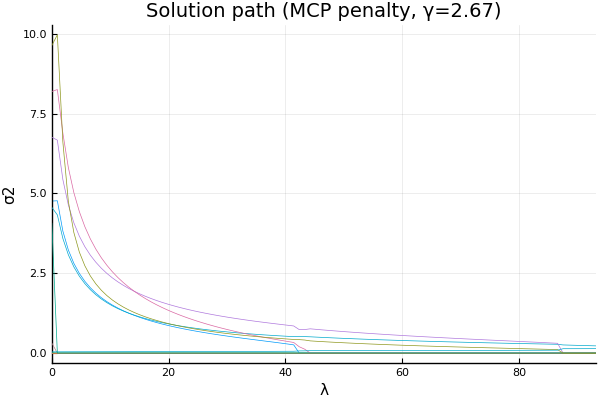

In [30]:
plot(λpath_mcp, σ2path_mcp', label="", xaxis=("λ", (minimum(λpath_mcp), maximum(λpath_mcp))), 
    yaxis=("σ2"), width=0.5)
title!("Solution path (MCP penalty, γ=2.67)")